In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import scipy.io as sio
import time
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Input, InputLayer, Flatten, Conv2D,MaxPooling2D,Conv2DTranspose,LeakyReLU
import seaborn as sn
from keras.utils.vis_utils import plot_model
import math
import pandas as pd
import matplotlib.gridspec as gridspec
import csv
from scipy.io import loadmat
from google.colab import files

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
def mean2(x):
    y = np.sum(x) / np.size(x);
    return y

def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / math.sqrt((a*a).sum() * (b*b).sum());
    return r

In [ ]:
Xtrain_digits_cs=np.transpose(sio.loadmat('/content/drive/My Drive/Colab Notebooks/Xtrain_digits_mnist_CS.mat')['Xtrain_digits'].squeeze()).reshape([60000,28*28],order='F')
outputTrain_digits_cs=np.transpose(sio.loadmat('/content/drive/My Drive/Colab Notebooks/outputTrain_digits_mnist_CS.mat')['outputTrain_digits'].squeeze()).reshape([60000,28*28],order='F')
y_train_labels=sio.loadmat('/content/drive/My Drive/Colab Notebooks/mnist_train_labels.mat')['YTrain'] 
train_inds_all=np.array([round(i) for i in np.linspace(0,59999,60000)])#to become indices of train/val later


In [ ]:
X_train_cs, X_val_cs, output_digits_train_cs, output_digits_val_cs, train_inds_train_cs, train_inds_val_cs= train_test_split(Xtrain_digits_cs, 
                                                    outputTrain_digits_cs,train_inds_all,
                                                    stratify=y_train_labels, 
                                                    test_size=0.1666666, random_state=42)

X_train_train_cs, X_train_val_cs, output_digits_train_train_cs, output_digits_train_val_cs=train_test_split(X_train_cs,output_digits_train_cs,
                                                              stratify=y_train_labels[train_inds_train_cs],
                                                              test_size=0.2, random_state=10)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 Encoder (Sequential)        (None, 7, 7, 60)          1347274   
                                                                 
 Decoder (Sequential)        (None, 28, 28, 1)         7967015   
                                                                 
Total params: 9,314,289
Trainable params: 9,314,289
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/70
1250/1250 - 167s - loss: 2.2944e-04 - val_loss: 1.6259e-04 - 167s/epoch - 133ms/step
Epoch 2/70
1250/1250 - 158s - loss: 1.5400e-04 - val_loss: 1.5244e-04 - 158s/epoch - 126ms/step
Epoch 3/70
1250/1250 - 157s - loss: 1.4308e-04 - val_loss: 1.4762e-04 - 157s/epoch - 126ms/step
Epoch 4/70
1250/1250 -

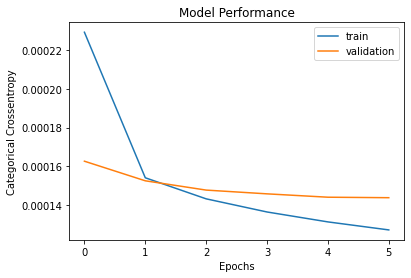

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Convolutional Autoencoder

# Train the Autoencoder
coding_size=60
filter_size=11
kernel_size=101
pool_size=2
convpad='same'
poolpad='same'

def build_conv_autoencoder(filter_size, kernel_size, pool_size, coding_size,convpad,poolpad):
    # # The encoder
    encoder = Sequential(name="Encoder")
    # encoder.add(InputLayer((784,)))
    encoder.add(Conv2D(filter_size, kernel_size, activation=LeakyReLU(), padding=convpad))
    encoder.add(MaxPooling2D(pool_size, padding=poolpad))
    encoder.add(Conv2D(filter_size, kernel_size, activation=LeakyReLU(), padding=convpad))
    encoder.add(MaxPooling2D(pool_size, padding=poolpad))
    # encoder.add(Dense(dense_size,activation='relu'))
    encoder.add(Dense(coding_size,activation=LeakyReLU()))

    # # The decoder
    decoder = Sequential(name="Decoder")
    # decoder.add(InputLayer((coding_size,)))#
    decoder.add(Conv2DTranspose(filter_size, kernel_size, strides=2, activation=LeakyReLU(), padding=convpad))
    decoder.add(Conv2DTranspose(filter_size, kernel_size, strides=2, activation=LeakyReLU(), padding=convpad))
    decoder.add(Conv2D(1, (1,1), activation=LeakyReLU(), padding='same'))

    return encoder, decoder    



encoder, decoder = build_conv_autoencoder(filter_size, kernel_size, pool_size, coding_size,convpad,poolpad)

inpt=Input(shape=(28,28,1))
code = encoder(inpt)
reconstruction = decoder(code)
autoencoder_cs=Model(inpt,reconstruction)
autoencoder_cs.compile(optimizer='adam', loss='mse')
print(autoencoder_cs.summary())

filepath="best_model_convTrained_on_CS.hdf5"
mc = ModelCheckpoint(filepath, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss',verbose=0,min_delta=0.01,patience=5)
callbacks=[es, mc]

train_new=1
if train_new==1:
    classify_model_trained_cs=autoencoder_cs.fit(X_train_train_cs.reshape([len(X_train_train_cs),28,28,1]),output_digits_train_train_cs.reshape([len(X_train_train_cs),28,28,1]),
                                                 validation_data=(X_train_val_cs.reshape([len(X_train_val_cs),28,28,1]), 
                                                 output_digits_train_val_cs.reshape([len(X_train_val_cs),28,28,1])),
                                                 epochs=70,verbose=2,callbacks=callbacks)
    
    best_epoch=np.argmin(classify_model_trained_cs.history['val_loss'])+1
    epochs = len(classify_model_trained_cs.history['loss'])
    
    makeTrainingPlot=1
    if makeTrainingPlot==1: #Make a plot of training progress
        plt.plot(range(epochs),classify_model_trained_cs.history['loss'], label='train')
        plt.plot(range(epochs),classify_model_trained_cs.history['val_loss'],label='validation')
        plt.xlabel('Epochs')
        plt.ylabel("Categorical Crossentropy")
        plt.title('Model Performance')
        plt.legend()
        plt.show()
    autoencoder_cs.load_weights(mc.filepath)
else:
    autoencoder_cs.load_weights(mc.filepath)

files.download(filepath)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 784)]             0         
                                                                 
 sequential (Sequential)     (None, 120)               398320    
                                                                 
 sequential_1 (Sequential)   (None, 784)               398984    
                                                                 
Total params: 797,304
Trainable params: 797,304
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/70
1250/1250 - 3s - loss: 2.5954e-04 - val_loss: 2.0251e-04 - 3s/epoch - 3ms/step
Epoch 2/70
1250/1250 - 3s - loss: 1.8652e-04 - val_loss: 1.8478e-04 - 3s/epoch - 2ms/step
Epoch 3/70
1250/1250 - 3s - loss: 1.7046e-04 - val_loss: 1.8079e-04 - 3s/epoch - 2ms/step
Epoch 4/70
1250/1250 - 3s - loss: 1.6121e-

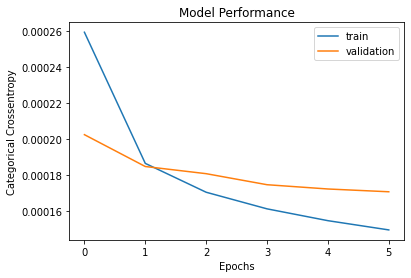

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#MLP on CS
dense_size=440
coding_size=120
def build_MLP_autoencoder(dense_size, coding_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer((784,)))
    encoder.add(Dense(dense_size,activation=LeakyReLU()))
    encoder.add(Dense(coding_size,activation=LeakyReLU()))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((coding_size,)))
    decoder.add(Dense(dense_size,activation=LeakyReLU()))
    decoder.add(Dense(784, activation=LeakyReLU()))
    return encoder, decoder


encoder_mlp_cs, decoder_mlp_cs = build_MLP_autoencoder(dense_size, coding_size)

inpt=Input((784,))
code_cs = encoder_mlp_cs(inpt)
reconstruction_cs = decoder_mlp_cs(code_cs)
autoencoder_mlp_cs=Model(inpt,reconstruction_cs)
autoencoder_mlp_cs.compile(optimizer='adam', loss='mse')
print(autoencoder_mlp_cs.summary())
plot_model(autoencoder_mlp_cs, show_shapes=True, to_file='mlp_autoencoder_CS.png',expand_nested=True)


filepath="best_model_mlpTrained_on_CS.hdf5"
mc = ModelCheckpoint(filepath, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss',verbose=0,min_delta=0.01,patience=5)
callbacks=[es, mc]

train_new=1
if train_new==1:
    classify_model_trained_mlp_cs=autoencoder_mlp_cs.fit(X_train_train_cs,output_digits_train_train_cs,
                                                 validation_data=(X_train_val_cs, 
                                                 output_digits_train_val_cs),
                                                 epochs=70,verbose=2,callbacks=callbacks)
    
    best_epoch=np.argmin(classify_model_trained_mlp_cs.history['val_loss'])+1
    epochs = len(classify_model_trained_mlp_cs.history['loss'])
    
    makeTrainingPlot=1
    if makeTrainingPlot==1: #Make a plot of training progress
        plt.plot(range(epochs),classify_model_trained_mlp_cs.history['loss'], label='train')
        plt.plot(range(epochs),classify_model_trained_mlp_cs.history['val_loss'],label='validation')
        plt.xlabel('Epochs')
        plt.ylabel("Categorical Crossentropy")
        plt.title('Model Performance')
        plt.legend()
        plt.show()
    autoencoder_mlp_cs.load_weights(mc.filepath)
else:
    autoencoder_mlp_cs.load_weights(mc.filepath)

files.download(filepath) 

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 784)]             0         
                                                                 
 sequential_2 (Sequential)   (None, 120)               653380    
                                                                 
 sequential_3 (Sequential)   (None, 784)               654044    
                                                                 
Total params: 1,307,424
Trainable params: 1,307,424
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/70
1250/1250 - 4s - loss: 2.6339e-04 - val_loss: 2.0206e-04 - 4s/epoch - 3ms/step
Epoch 2/70
1250/1250 - 3s - loss: 1.8649e-04 - val_loss: 1.8921e-04 - 3s/epoch - 3ms/step
Epoch 3/70
1250/1250 - 3s - loss: 1.6866e-04 - val_loss: 1.8171e-04 - 3s/epoch - 3ms/step
Epoch 4/70
1250/1250 - 4s - loss: 1.58

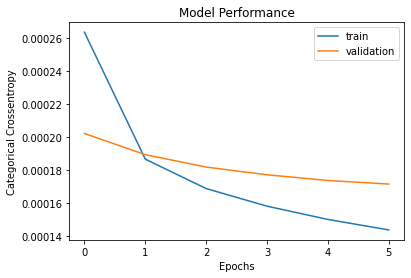

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#%% Deep MLP Trained on CS

dense_size_outer=480
dense_size_inner=460
coding_size=120
def build_deep_autoencoder(dense_size_outer, dense_size_inner, coding_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer((784,)))
    encoder.add(Dense(dense_size_outer,activation=LeakyReLU()))
    encoder.add(Dense(dense_size_inner,activation=LeakyReLU()))
    encoder.add(Dense(coding_size,activation=LeakyReLU()))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((coding_size,)))
    decoder.add(Dense(dense_size_inner,activation=LeakyReLU()))
    decoder.add(Dense(dense_size_outer,activation=LeakyReLU()))
    decoder.add(Dense(784, activation=LeakyReLU()))
    return encoder, decoder


encoder_deep_mlp_cs, decoder_deep_mlp_cs = build_deep_autoencoder(dense_size_outer, dense_size_inner, coding_size)

inpt=Input((784,))
code_cs = encoder_deep_mlp_cs(inpt)
reconstruction_cs = decoder_deep_mlp_cs(code_cs)
autoencoder_deep_mlp_cs=Model(inpt,reconstruction_cs)
autoencoder_deep_mlp_cs.compile(optimizer='adam', loss='mse')
print(autoencoder_deep_mlp_cs.summary())
plot_model(autoencoder_deep_mlp_cs, show_shapes=True, to_file='deep_mlp_autoencoder_CS.png',expand_nested=True)


filepath="best_model_deep_mlpTrained_on_CS.hdf5"
mc = ModelCheckpoint(filepath, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss',verbose=0,min_delta=0.01,patience=5)
callbacks=[es, mc]

train_new=1
if train_new==1:
    classify_model_trained_deep_mlp_cs=autoencoder_deep_mlp_cs.fit(X_train_train_cs,output_digits_train_train_cs,
                                                 validation_data=(X_train_val_cs, 
                                                 output_digits_train_val_cs),
                                                 epochs=70,verbose=2,callbacks=callbacks)
    
    best_epoch=np.argmin(classify_model_trained_deep_mlp_cs.history['val_loss'])+1
    epochs = len(classify_model_trained_deep_mlp_cs.history['loss'])
    
    makeTrainingPlot=1
    if makeTrainingPlot==1: #Make a plot of training progress
        plt.plot(range(epochs),classify_model_trained_deep_mlp_cs.history['loss'], label='train')
        plt.plot(range(epochs),classify_model_trained_deep_mlp_cs.history['val_loss'],label='validation')
        plt.xlabel('Epochs')
        plt.ylabel("Categorical Crossentropy")
        plt.title('Model Performance')
        plt.legend()
        plt.show()
    autoencoder_deep_mlp_cs.load_weights(mc.filepath)
else:
    autoencoder_deep_mlp_cs.load_weights(mc.filepath)

files.download(filepath)